# Training a Neural Network Model with FFBP
This notebook provides instructions on how to create, train, test, and analyze a feedforward neural network model using pdpyflow's FFBP package and Tensorflow. If you don't have any experience with Tensorflow, try the [getting started tutorial](https://github.com/alex-ten/pdpyflow/blob/master/tutorials/getting_started/getting_started.ipynb) or visit the [website](https://www.tensorflow.org/get_started/) to get more information. The FFBP package is intended to simplify the process of constructing a [Tensorflow Graph](https://www.tensorflow.org/programmers_guide/graphs) for neural network modeling. A Tensorflow graph is a computational structure that *describes* the flow of data (tensors) through various computational operations. Thus, the processes of constructing a graph and running it are separate, as is the analysis of data generated by running a model.

Therefore, training or testing, and analyzing a neural network involves the following steps:
- Preparing input data ([tutorial](https://github.com/alex-ten/pdpyflow/blob/master/tutorials/building_models/prepare_input.ipynb)) [&#x21F1;](#step1)
- Constructing a model ([tutorial](https://github.com/alex-ten/pdpyflow/blob/master/tutorials/building_models/build_model.ipynb)) [&#x21F1;](#step2)
- Running the model [&#x21F1;](#step3)
- Accessing and analyzing data ([tutorial](https://github.com/alex-ten/pdpyflow/blob/master/tutorials/building_models/analyzing_data.ipynb)) [&#x21F1;](#step4)

This tutorial gives an overview of these steps, but more information on some of them is provided in the corresponding links. See those if you feel like you need more understanding of what is laid out below. To illustrate how a neural network model can be created, trained, tested, and analyzed, we use as an example the model of [semantic cognition](https://mitpress.mit.edu/books/semantic-cognition) by Rogers and McClelland. The model is a feedforward neural network with two input layers, two hidden layers, and an output layer. 

We begin by importing the packages required for this tutorial and creating a Tensorflow graph. We want to make sure that we are adding various network and data [enqueueing](https://www.tensorflow.org/versions/r0.12/api_docs/python/io_ops/queues) elements to this graph. To achieve, this we will use the graph's handle with Python's **`with`** statements, threreby creating a [context manager](https://docs.python.org/3/reference/datamodel.html#context-managers) which allows elaborating the graph.

In [1]:
import tensorflow as tf
import FFBP
from FFBP.vis_utils2 import view_layers
tf.logging.set_verbosity(tf.logging.ERROR) # Prevent unwanted logging messages by tensorflow

FFBP_GRAPH = tf.Graph()

/Users/alexten/Environments/pdpyflow_env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


<a id='step1'> </a>
## Preparing input data
A detailed documentation of the `FFBP.InputData` class is provided in a separate [tutorial](https://github.com/alex-ten/pdpyflow/blob/master/tutorials/building_models/prepare_input.ipynb). Here, we create two instances of the `FFBP.InputData` class, one for training (`TRAIN_DATA`) and one for testing (`TEST_DATA`). The `shuffle_seed` argument is set to `1` (for reproducibility) only for the training data set; we don't want to shuffle the test items (so we omit it for `TEST_DATA`). Note that the `inp_size` argument is a tuple of two integers corresponding to the sizes of item and relation layers, respectively. Although we are using the same data set for training and testing, it is possible to use different ones.

In [2]:
with FFBP_GRAPH.as_default():
    
    # Create data for training
    TRAIN_DATA = FFBP.InputData(
        path_to_data_file = 'materials/semantic_data.txt',
        batch_size        = 1,
        inp_size          = (8,4), # same as the sizes of item and relation layers
        targ_size         = 36,    # same as the size of the attribute layer
        data_len          = 32,    # number of training examples
        shuffle_seed      = -1     # -N for random seed, N for non-random seed, None to turn off randomization
    )
    
    # Create data for testing
    TEST_DATA = FFBP.InputData(
        path_to_data_file = 'materials/semantic_data.txt',
        batch_size        = 1,
        inp_size          = (8,4), 
        targ_size         = 36,
        data_len          = 32
    )

<a id='step2'> </a>
## Constructing a model
A detailed documentation of the objects specified further, including `FFBP.BasicLayer` and `FFBP.Model` is provided in a separate [tutorial](https://github.com/alex-ten/pdpyflow/blob/master/tutorials/building_models/build_model.ipynb). Below is an example of how to outline the network structure and specify the flow of data for the semantic network. We specify arbitrary random initialization seeds (`2`, `3`, and `4`, respectively) for reproducibility. Note that `hidden_layer` takes the concatenation of tensors computed by `representation_layer.output` and `relation_inp` as input, so the `layer_input` argument to this layer is given as a tuple containing the two.

In [3]:
wr = 0.1 # weight initialization range

# Add network components to the graph
with FFBP_GRAPH.as_default():
    
    MODEL_NAME = 'semantic_net'
    with tf.name_scope(MODEL_NAME):
        
        # Input placeholders (input layers)
        ITEM_INP     = tf.placeholder(dtype = tf.float32, shape=[None, 8], name='item_inp')
        RELATION_INP = tf.placeholder(dtype = tf.float32, shape=[None, 4], name='relation_inp')
        
        # First hidden layer (representation)
        REPRESENTATION_LAYER = FFBP.BasicLayer(
            layer_name  = 'representation_layer', 
            layer_input = ITEM_INP, 
            size        = 8, 
            wrange      = [-wr, wr], 
            nonlin      = tf.nn.sigmoid, 
            seed        = 2, # -N for random seed, N for seed = N
        )
        
        # Second hidden layer
        HIDDEN_LAYER = FFBP.BasicLayer(
            layer_name  = 'hidden_layer', 
            layer_input = (REPRESENTATION_LAYER.output, RELATION_INP),
            size        = 15, 
            wrange      = [-wr, wr], 
            nonlin      = tf.nn.sigmoid, 
            seed        = 3
        )
        
        # Output layer
        ATTRIBUTE_LAYER = FFBP.BasicLayer(
            layer_name  = 'attribute_layer', 
            layer_input = HIDDEN_LAYER.output, 
            size        = 36, 
            wrange      = [-wr, wr], 
            nonlin      = tf.nn.sigmoid, 
            seed        = 4
        )
        
        # Target placeholder
        TARGET = tf.placeholder(dtype = tf.float32, shape=[None, 36], name='targets')
        
        # Optimization specs
        OPTIMIZER = tf.train.GradientDescentOptimizer(learning_rate=.1, name='SGD_optimizer')
        LOSS = tf.reduce_sum(tf.squared_difference(TARGET, ATTRIBUTE_LAYER.output), name='loss')
        
        # Model
        MODEL = FFBP.Model(
            name       = MODEL_NAME,
            layers     = [REPRESENTATION_LAYER, HIDDEN_LAYER, ATTRIBUTE_LAYER],
            train_data = TRAIN_DATA, 
            test_data  = TEST_DATA,
            inp        = [ITEM_INP, RELATION_INP],
            targ       = TARGET,
            loss       = LOSS,
            optimizer  = OPTIMIZER,
        )

<a id='step3'> </a>
## Running the model
The model is run inside two for-loops (one nested inside the other): the (inner) train loop and the (outer) run loop. In a single iteration of the run loop, model parameters are initialized either randomly or by restoration from an existing checkpoint directory. A single iteration of the inner train loop corresponds to a single epoch of training/testing. Thus, minimally, a valid run routine would look something like this:
```python
# start outer run loop
for run_ind in range(NUM_RUNS):
    
    # open new session for existing graph
    with tf.Session(graph=FFBP_GRAPH) as sess:
        
        # initialize variables and start queue
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())
        coordinator = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coordinator)
        
        # start inner epoch loop
        for i in range(NUM_EPOCHS):
            test_loss, snapshot = MODEL.test_epoch(session=sess, verbose=True)
            train_loss = MODEL.train_epoch(session=sess, verbose=False)
        
        # stop queues
        coordinator.request_stop()
        coordinator.join(threads)

```
Here, we start a new Tensorflow session for a `NUM_RUNS` number of iterations and iterate over the `range(NUM_RUNS)`. Within each session, we randomly initilize all global and local variables (this reinitializes model parameters and local queue variables), start the queues, and run the train loop. Inside the train loop we test and train the model for a `NUM_EPOCHS` number of times.

In order to store test data, as well as to [save/restore](https://www.tensorflow.org/programmers_guide/saved_model) it we need to make a few additions. For this the `FFBP.ModelSaver` class is available. The constructor takes up to two arguments:
- **`restore_from`** : (*default*=`None`) a string path to a restoration directory which contains model checkpoint files. The path can be either absolute (e.g. `/Users/username/path/to/file`) or relative to the working directory of the current notebook.
- **`logdir`** : (*default*=`None`) a string path to the log directory where model parameters and test data will be saved. If `None` a new directory (e.g. `/logdirs/logdir_000`) is automatically created in the same location as the current notebook. Depending on what one decides to save, this directory will contain a checkpoints subdirectory from which model parameters could be restored and `runlog.pkl` file(s) containing test data from a single model run. Detailed instructions on how to access data from runlogs can be found [here](https://github.com/alex-ten/pdpyflow/blob/master/tutorials/building_models/analyze_data.ipynb).

The saver includes several methods for saving and/or restoring model parameters as well as for storing test data:
- **`init_model`**`(`*`session, init_epoch=0`*`)` : initializes model parameters. If the saver contains a restore path, the parameters will be restored from the existing checkpoint directory. Otherwise, the parameters will be initialized anew, based on the value of `wrange` for each individual layer. The `session` argument is required and should be the current session of the run. The user has control over indexing the initial epoch via the `init_epoch` parameter. The value of `init_epoch` is returned if the model is initialized from scratch, and a restored value is returned if the model is restored from a checkpoint.
- **`save_model`**`(`*`session, model`*`)` : saves a given *`model`* to the saver's `logdir` and returns the string path of the log directory.
- **`save_test`**`(`*`snap, run_ind`*`)` : saves a given *`snapshot`* to the corresponding runlog indexed by *`run_ind`* and returns the string path of the log directory.
- **`save_loss`**`(`*`loss, run_ind`*`)` : saves a given *`loss`* to the corresponding runlog indexed by *`run_ind`* and returns the string path of the log directory.

Below provide the run routine that executes a run of training, intermitted by occasional pre-tests. The training will proceed for the given number of epochs or until the train loss goes below the `ECRIT`. Regardless of when the training ends, the model will be tested one final time and saved (if `SAVE_FINAL=True`). Model parameters and test data will be stored at a new log directory, producing a new file indexed by `run_ind` (e.g. `checkpoints_directory_0` and `runlog_0.pkl`).

All of the run parameters are brought to the top of the cell for presentation. We specify `TEST_EPOCHS` outside the run loop as a list of integer values. The model will be pre-tested on the 1<sup>st</sup> (epoch 0), 500<sup>th</sup>, 1000<sup>th</sup>, 2000<sup>th</sup>, and 5000<sup>th</sup> epochs. If the user wants to checkpoint the model occasionally, `SAVE_EPOCHS` should be a similar list specifying when the model parameters are to be saved. The code below does not checkpoint the model at any point, but the corresponding run parameters (`SAVE_EPOCHS=[None]` and `SAVE_FINAL=False`) are provided for illustration. Running the following cell will print out the test losses, indexed by the corresponding epoch and run.

In [4]:
%%bash
rm -rf logdirs

In [5]:
# Set up run parameters
NUM_RUNS    = 1
NUM_EPOCHS  = 10 # change to 5000
TEST_EPOCHS = [0,2,5,7,9]# change to [0, 499, 999, 1999, 4999]
SAVE_EPOCHS = [None]
SAVE_FINAL  = False
ECRIT       = 0.05

# Create a model saver
saver = FFBP.ModelSaver(restore_from=None, logdir=None)

# Start run loop
for run_ind in range(NUM_RUNS):
    print('>>> RUN {}'.format(run_ind))
    
    with tf.Session(graph=FFBP_GRAPH) as sess:

        # restore or initialize FFBP_GRAPH variables:
        start_epoch = saver.init_model(session=sess)

        # create coordinator and start queue runners
        coordinator = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coordinator)
        
        # Start train loop
        for i in FFBP.prog_bar(
            sequence=range(start_epoch, start_epoch + NUM_EPOCHS), 
            name='Run {}/{}, Epoch'.format(run_ind,NUM_RUNS),
            every=1):
            
            # Test model occasionally
            if any([i==test_epoch for test_epoch in TEST_EPOCHS]):
                test_loss, snapshot = MODEL.test_epoch(session=sess, verbose=True)
                saver.save_test(snapshot, run_ind)

            # Run one training epoch
            train_loss = MODEL.train_epoch(session=sess, verbose=False)
            saver.save_loss(train_loss, run_ind)

            # Save model occasionally
            if any([i==save_epoch for save_epoch in SAVE_EPOCHS]):
                saver.save_model(session=sess, model=MODEL, run_ind=run_ind)

            # Do final test, stop queues, and break out from training loop
            if train_loss < ECRIT or i == start_epoch + (NUM_EPOCHS - 1): 
                print('Final test ({})'.format(
                    'loss < ecrit' if train_loss < ECRIT else 'reached last epoch'))

                test_loss, snapshot = MODEL.test_epoch(session=sess, verbose=True)
                saver.save_test(snapshot, run_ind)

                coordinator.request_stop()
                coordinator.join(threads)

                if SAVE_FINAL: saver.save_model(session=sess, model=MODEL, run_ind=run_ind)
                break

FFBP Saver: logdir path: /Users/alexten/Projects/pdpyflow/tutorials/building_models/logdirs/logdir_000
>>> RUN 0
FFBP Saver: initializing local and global variables from scratch


Widget Javascript not detected.  It may not be installed or enabled properly.


Epoch 0: 283.65135765075684
Epoch 2: 83.66200625896454
Epoch 5: 81.7902843952179
Epoch 7: 81.66452294588089
Epoch 9: 81.4374241232872
Final test (reached last epoch)
Epoch 10: 81.3842025399208


<a id='step4'> </a>
## Accessing and analyzing the results

- (5) Accessing, analyzing and displaying results*
 
sub-tutorial indicates how to start visualizer and access individual runs/epochs
 
analysis loop on the results of a single run to report:
 
- (1) splice together the output of the network across all four contexts
 
- (2) display the spliced output for each of the eight inputs items
 
- (3) display the svd of the spliced outputs
 

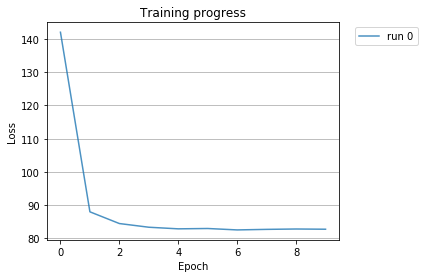

In [6]:
FFBP.view_progress(
    logdir = saver.logdir, 
    gaussian_smoothing = 0
)

<IPython.core.display.Javascript object>


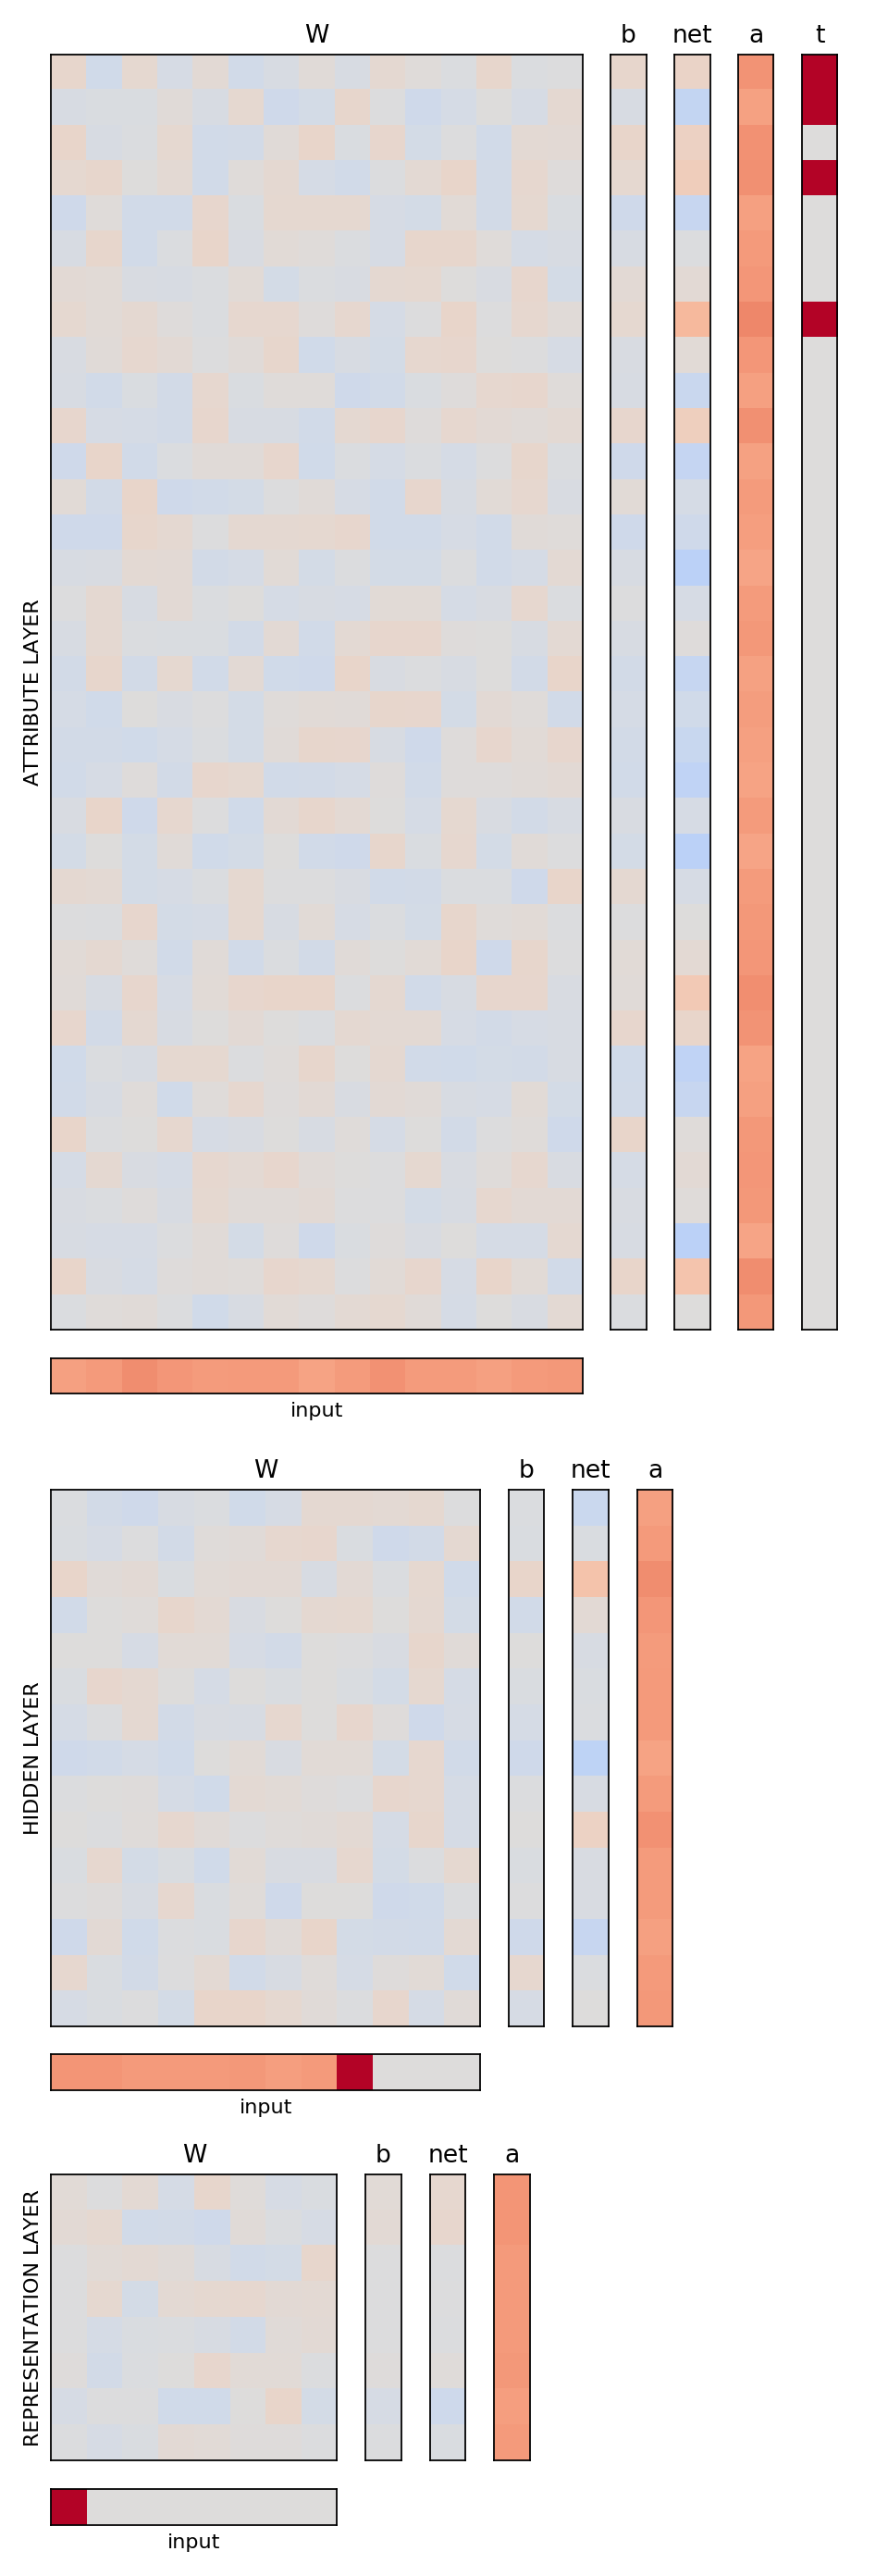

Widget Javascript not detected.  It may not be installed or enabled properly.


In [7]:
view_layers(
    logdir = saver.logdir,
    mode = 0
)